# Experiment 6#

Train on Food101 image with size 512x512 use ResNet50 model with data augmentation

In [1]:
import zipfile
import os

files = zipfile.ZipFile('food101.zip', 'r')
files.extractall(os.getcwd())
files.close()  

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# imports
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import seaborn as sns

In [3]:
path = Path('food101')
path_meta = path /'meta'
path_images = path/'images'

In [4]:
def build_data_frame(path_name, file_name, img_format = 'jpg'):
    """
    build_data_frame input the path and file name, the function will return the dataframe with two columns:
    ['label'] : image label
    ['image_file'] : image file name with directory information
    input paramters:
    path_name : path 
    file_name : file name, string
    img_format : default format is jpg
    
    return dataframe
    """
    path_file = path_name/file_name
    file_df = pd.read_csv(path_file,delimiter='/', header=None, names=['label', 'image_file'])
    file_df['image_file'] = file_df['label'].astype(str) + '/' + file_df['image_file'].astype(str) + '.'+img_format
    
    return file_df

In [5]:
train_df = build_data_frame(path_meta, 'train.txt')
test_df = build_data_frame(path_meta, 'test.txt')

In [6]:
train_df.head()

,label,image_file
0,apple_pie,apple_pie/1005649.jpg
1,apple_pie,apple_pie/1014775.jpg
2,apple_pie,apple_pie/1026328.jpg
3,apple_pie,apple_pie/1028787.jpg
4,apple_pie,apple_pie/1043283.jpg


In [7]:
bs = 64
train_data = ImageList.from_df(df=train_df,path=path_images, cols=1)\
              .split_by_rand_pct(0.2)\
              .label_from_df(cols=0)\
              .transform(get_transforms(), size=512)\
              .databunch(bs=bs)

In [8]:
Crop_pads = RandTransform(tfm=TfmCrop(crop_pad),\
                       kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, \
                       p=1.0, \
                       resolved={}, \
                       do_run=True, \
                       is_random=True)

Affine_flip = RandTransform(tfm=TfmAffine(flip_affine),\
                            kwargs={}, \
                            p=0.5, \
                            resolved={}, \
                            do_run=True, \
                            is_random=True)

Coord_warp = RandTransform(tfm=TfmCoord(symmetric_warp), \
                           kwargs={'magnitude': (-0.2, 0.2)}, \
                           p=0.75, \
                           resolved={}, \
                           do_run=True, \
                           is_random=True)

Affine_rotate = RandTransform(tfm=TfmAffine(rotate),\
                              kwargs={'degrees': (-20.0, 20.0)}, \
                              p=0.75, \
                              resolved={}, \
                              do_run=True, \
                              is_random=True)

Affine_zoom = RandTransform(tfm=TfmAffine(zoom), \
                            kwargs={'scale': (1.0, 1.3), 'row_pct': (0, 1), 'col_pct': (0, 1)}, \
                            p=0.75, \
                            resolved={}, \
                            do_run=True, \
                            is_random=True)

Lighting_brightness = RandTransform(tfm=TfmLighting(brightness), \
                         kwargs={'change': (0.4, 0.6)}, \
                         p=0.75, \
                         resolved={}, \
                         do_run=True, \
                         is_random=True)

Lighting_contrast = RandTransform(tfm=TfmLighting(contrast),\
                                  kwargs={'scale': (0.8, 1.25)}, \
                                  p=0.75, \
                                  resolved={}, \
                                  do_run=True,\
                                  is_random=True)

Crops = RandTransform(tfm=TfmCrop(crop_pad), \
                      kwargs={}, \
                      p=1.0, \
                      resolved={},\
                      do_run=True, \
                      is_random=True)


train_tfms = [Crop_pads,Affine_flip,Coord_warp,Affine_rotate,Affine_zoom,Lighting_brightness,Lighting_contrast]


valid_tfms = [Crops]

random_tfms = (train_tfms,valid_tfms)


In [9]:
bs=64
bs_512 = int(bs/4)

train_model_data = (ImageList.from_df(df=train_df,path=path_images, cols=1)\
                            .split_by_rand_pct(0.2)\
                            .label_from_df(cols=0)\
                            .transform(random_tfms,size=512)\
                            .databunch(bs=bs_512)\
                            .normalize(imagenet_stats))
recompute_scale_factor=True

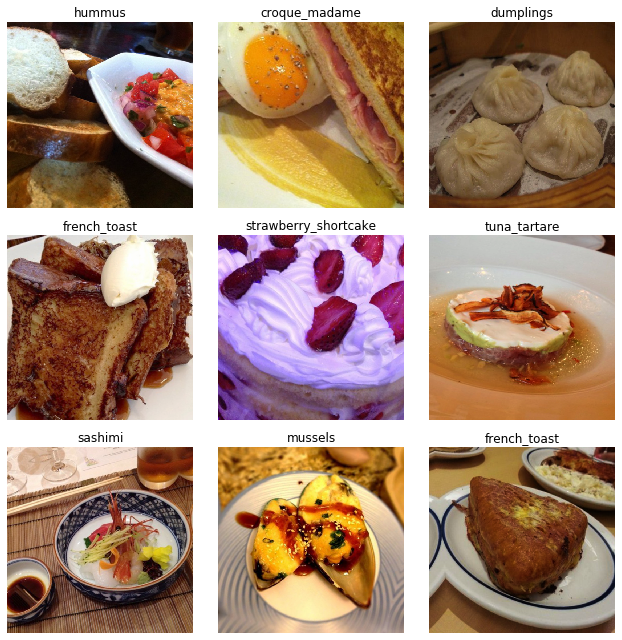

In [10]:
train_model_data.show_batch(rows=3, figsize=(9, 9))

In [11]:
#ResNet50 pre-trained model

top_5_accuracy = partial(top_k_accuracy, k=5)

learn = cnn_learner(train_model_data, models.resnet50, metrics=[accuracy, top_5_accuracy], callback_fns=ShowGraph)

In [12]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=101, bias=True)
)

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


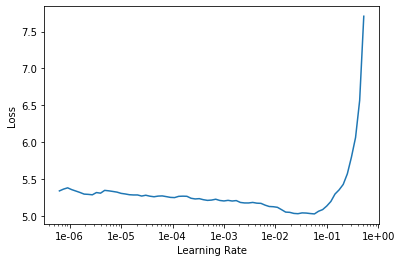

In [14]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.992224,1.527841,0.602112,0.847789,21:41
1,2.007325,1.699708,0.603432,0.850429,21:43
2,1.934181,2.937028,0.629043,0.859802,21:44
3,1.752367,2.221498,0.661584,0.881584,21:43
4,1.576395,3.171218,0.692277,0.893597,21:47
5,1.316626,1.127868,0.735842,0.914455,21:44
6,1.194597,1.220334,0.760264,0.924158,21:37
7,1.055589,1.233910,0.767987,0.926601,21:42


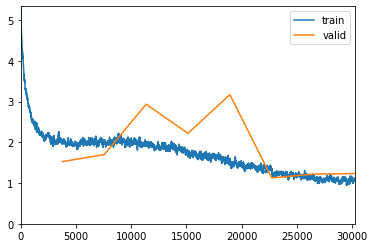

In [15]:
lr = 1e-2
learn.fit_one_cycle(8, slice(lr))
learn.save('food-101-ResNet50-512-yesno')

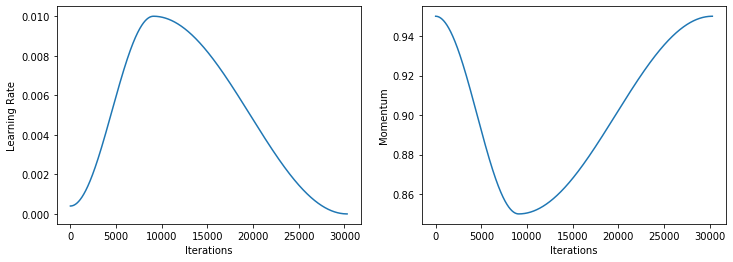

In [16]:
learn.recorder.plot_lr(show_moms=True)

# Experiment 7#

Train on Food101 image with size 512x512 use unfreeze ResNet50 model with data augmentation

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


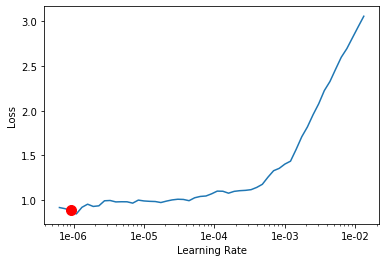

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.028182,0.874011,0.774917,0.931551,28:51
1,1.052274,1.692854,0.772673,0.930099,28:52
2,0.983299,0.978889,0.784488,0.933597,28:54
3,0.874134,0.829077,0.794851,0.940528,29:02
4,0.801324,0.940208,0.800330,0.941980,29:00
5,0.788112,0.898471,0.804819,0.943762,29:03
6,0.696504,1.058211,0.809505,0.945017,29:02
7,0.671450,0.791079,0.807789,0.945082,29:02


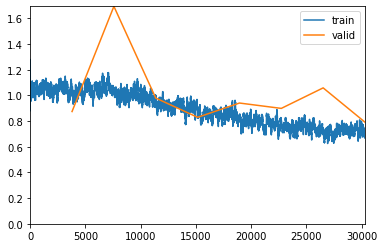

In [18]:
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-4))
learn.save('food-101-ResNet50-512-yesyes')

In [19]:
test_model_data = (ImageList.from_df(df=test_df,path=path_images, cols=1)\
                            .split_none()\
                            .label_from_df(cols=0)\
                            .transform(random_tfms,size=512)\
                            .databunch(bs=bs_512)\
                            .normalize(imagenet_stats))

learn = cnn_learner(test_model_data, models.resnet50, metrics=[accuracy, top_5_accuracy], callback_fns=ShowGraph)

#learn.load('food-101-ResNet50-1e-9-4-v2-512')
learn.load('food-101-ResNet50-512-yesyes')

Learner(data=ImageDataBunch;

Train: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: food101/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: food101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2

In [20]:
learn.validate(test_model_data.train_dl)

[0.6265126, tensor(0.8468), tensor(0.9679)]

In [21]:
#Model: food-101-ResNet50-1e-57-55-v2-512
y_preds_TTA, y_TTA = learn.TTA(ds_type= test_model_data,beta=0.4, scale=1.35)

top_1_accuracy_TTA = accuracy(y_preds_TTA, y_TTA)
top_5_accuracy_TTA = top_k_accuracy(y_preds_TTA, y_TTA, k=5)

print('TTA: top_1_accuracy: ',top_1_accuracy_TTA )
print('TTA: top_5_accuracy: ',top_5_accuracy_TTA )

TTA: top_1_accuracy:  tensor(0.8660)
TTA: top_5_accuracy:  tensor(0.9730)


In [20]:
#torch.cuda.empty_cache()